## Multivariable Logistic Regression



GLMs take one explantory variable; $x_1$

We take the $\beta_1$ conefficient and $\beta_0$ for the incercept

$ logit(y) = \beta_0 + \beta_1 x_1 $

However, in all likelihood we'll want additional variables, $x_2$ to $x_p$

$ logit(y) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p $

The betas provide information on the effect of x (on the log dds that y equals 1, controlling for other x's), x is the estimated parameter

Exponentional of beta is the odds of the 1 unit increase in x, assuming fixed levels of other x's

```
model = glm('y ~ x1 + x2 + x3 + x4`,
    data=my_data,
    family = sm.families.Binomial()).fit()
```

**Adding variables impacts the coefficient of other variables**

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

df_wells = pd.read_csv('wells.csv')

wells_fit_mv = glm(formula = 'switch ~ distance100 + arsenic',
               data= df_wells,
               family = sm.families.Binomial()).fit()

wells_fit_sv = glm(formula = 'switch ~ distance100',
               data= df_wells,
               family = sm.families.Binomial()).fit()

print(f'Distance100 coefficient in multi-variable; {round(wells_fit_mv.params.distance100,2)}')

print(f'\nDistance100 coefficient in single-variable; {round(wells_fit_sv.params.distance100,2)}')

print('''
This is attributed to the fact that the further the current well is from the nearest safe well, 
the level of arsenic in the current well is likely to be high.
ie - this highlights the concept of multi-collinearity
''')

Distance100 coefficient in multi-variable; -0.91

Distance100 coefficient in single-variable; -0.63

This is attributed to the fact that the further the current well is from the nearest safe well, 
the level of arsenic in the current well is likely to be high.
ie - this highlights the concept of multi-collinearity



**Multicollinearity**

When variables are correlated with one another

This leads to inflation of standard errors - coefficients are therefore less likely to be statistically significant

Test for multicollinearity be adding and removing variables, then seeing to what extent coefficients change and checking for variables that have a high pairwise correlation

Variance inflation factor (VIF) - is the most widely used diagnostic for multicollinearity
<br>it describes how inflated the variance of the coefficient is, compared to what it would be if the variables were not correlated with any other variable in the model

2.5 is a general thresold for VIF

`from statsmodels.stats.outliers_influence import variance_inflation_factor`

In [22]:
df_crab = pd.read_csv('crab.csv')

# Define model formula
formula = 'y ~ width + color'

# Fit GLM
model = glm(formula, data = df_crab, family = sm.families.Binomial()).fit()

# Print model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      170
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.561
Date:                Wed, 22 Apr 2020   Deviance:                       189.12
Time:                        16:08:02   Pearson chi2:                     170.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0708      2.807     -3.588      0.0

In [23]:
# Import functions
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get variables for which to compute VIF and add intercept term
X = df_crab[['weight', 'width', 'color']]
X['Intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# View results using print
print(vif)

   variables         VIF
0     weight    4.691018
1      width    4.726378
2      color    1.076594
3  Intercept  414.163343


<ipython-input-23-0b51b1ee4ca6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = 1


### Measuring model mit

__Deviance__ is a goodness-of-fit measure
<br>Deviance tests the null hypothesis that the fitted model is correct

We want to measure whether our model is correctly specified and if we add more complexity would it better

Deviance is measured in terms of log-likelihood 

Formually, engative two times the log-likelihood of the model fit

$$ D = -2LL(\beta) $$

Deviance represents a measure of an error

Lower deviance means better model fit

The benchmark for the null hypothesis is the null deviance - here we only use the intercept term

Adding varables should decrease the deviance and therefore result in a better fit

Evaluation;
- Adding a random noise variable would, on average, decrease deviance by 1
- Adding $p$ predictors to the model deviance should decrease by more than $p$

Log-likelihood and deviance are provided in the summary function of GLMs

In [27]:
print(f'Null deviance = {model.null_deviance}')

print(f'Deviance with width and color ={model.deviance}')

print(f'Improvement = {model.deviance - model.null_deviance}')

print(f'Log-likelihood = {model.llf}')

print(f'Deviance using log-likelihood = {-2 * model.llf}')

Null deviance = 225.758523259302
Deviance with width and color =189.1211770746813
Improvement = -36.6373461846207
Log-likelihood = -94.56058853734065
Deviance using log-likelihood = 189.1211770746813


__Model complexity__

Adding complexity and reducing deviance does not always result in a better model

Adding complexity will typically result in overfitting

This results in an inability for models to generalise on new data

In [28]:
model_dist = glm(formula = 'switch ~ distance100',
               data= df_wells,
               family = sm.families.Binomial()).fit()

model_dist_ars = glm(formula = 'switch ~ distance100 + arsenic',
               data= df_wells,
               family = sm.families.Binomial()).fit()

# Compute the difference in adding distance100 variable
diff_deviance_distance = model_dist.null_deviance - model_dist.deviance

# Print the computed difference in deviance
print('Adding distance100 to the null model reduces deviance by: ', 
      round(diff_deviance_distance,3))

# Compute the difference in adding arsenic variable
diff_deviance_arsenic = model_dist.deviance - model_dist_ars.deviance

# Print the computed difference in deviance
print('Adding arsenic to the distance model reduced deviance further by: ', 
      round(diff_deviance_arsenic,3))

Adding distance100 to the null model reduces deviance by:  42.726
Adding arsenic to the distance model reduced deviance further by:  146.037


Formula and model matrix

Under the hood, the pasty package is used to construct the model matrix

This is done when the fit function is called,
note, the intercept is added silently



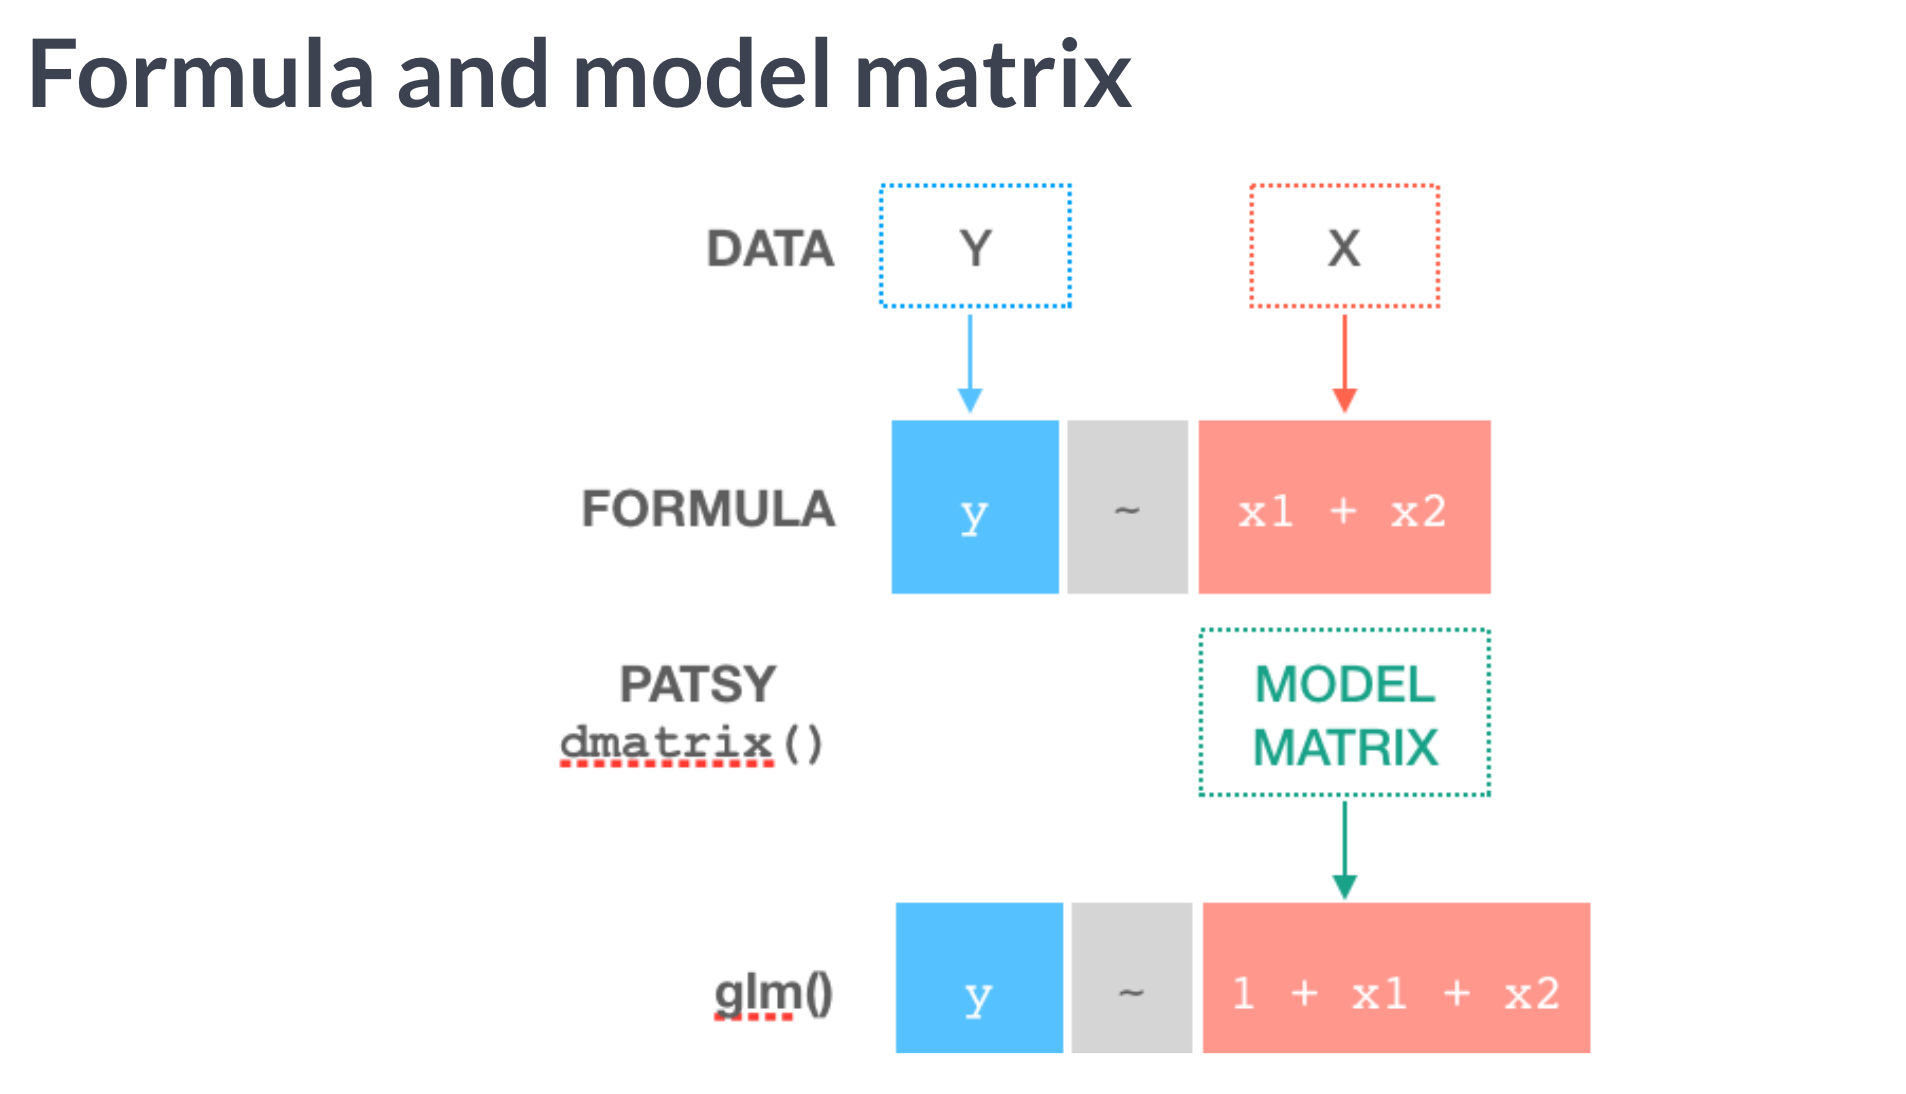

In [31]:
from IPython.display import Image
print('Formula and model matrix\n')
print('Under the hood, the pasty package is used to construct the model matrix\n')
print('This is done when the fit function is called,\nnote, the intercept is added silently\n')
Image('modelmatrix.png', width=600, height=800)

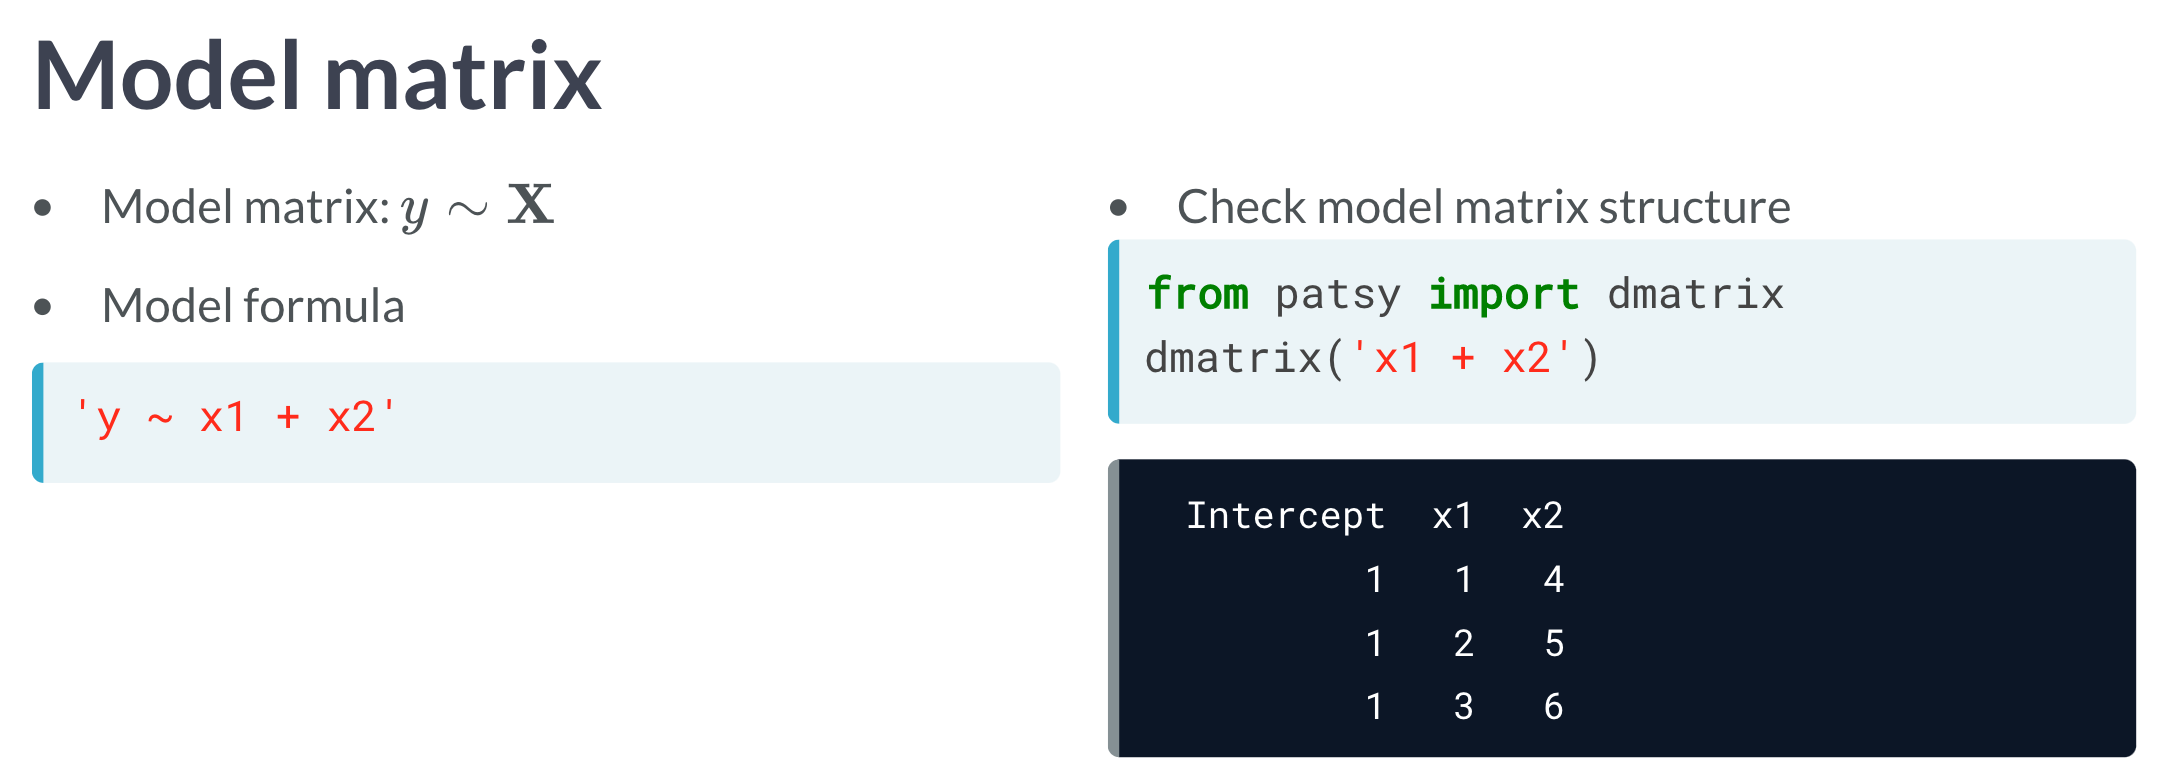

In [32]:
Image('dmatrix.png', width=600, height=800)

Transforming, centring and standardising variables can all be done directly in the formula argument

`formula = y ~ center(x1) + standardize(x2) + np.log(x3)`

Centring subtracts the mean

Standardising subtracts the means and divides by the sample std

These are stateful transforms - they remember the state of the original data
<br>allowing the original to be used later and will transform new data

You can define your own transformation

```
def my_transformation(x):
    return 4 * x    
```

`formula = y ~ x1 + x2 + mytransformation(x2)`


__categorical data__

MR; scipy preprocessing `OneHotEncoder()` seems far better than statsmodels

The c function lets us code categorical variables, coding a binary column for each value in color
<br>`y ~ 'C(color)'`

To view the model matrix
<br>`dmatrix('C(color)', data = crab)`

The  function lets us do bitwise arthimetic (adding up arrays)

In [35]:
# Import function dmatrix()
from patsy import dmatrix

# Construct model matrix with arsenic
model_matrix = dmatrix('arsenic', data = df_wells, return_type = 'dataframe')

model_matrix.head()

,Intercept,arsenic
0,1.0,2.36
1,1.0,0.71
2,1.0,2.07
3,1.0,1.15
4,1.0,1.10


In [36]:
model_matrix = dmatrix('arsenic + distance100', data = df_wells, return_type = 'dataframe')

model_matrix.head()

,Intercept,arsenic,distance100
0,1.0,2.36,0.16826
1,1.0,0.71,0.47322
2,1.0,2.07,0.20967
3,1.0,1.15,0.21486
4,1.0,1.10,0.40874


In [44]:
# Define model formula
formula = 'switch ~ np.log(arsenic)'

# Fit GLM
model_log_ars = glm(formula, data = df_wells, 
                     family = sm.families.Binomial()).fit()

model_ars = glm('switch ~ arsenic', data = df_wells, 
                     family = sm.families.Binomial()).fit()

print(f'Change in deviance using log transformation of arsenic; {round(model_log_ars.deviance - model_ars.deviance,3)}')

Change in deviance using log transformation of arsenic; -19.328


__Categorical data__

In [51]:
# Construct and print model matrix for color as categorical variable
dmatrix('C(color)', data = df_crab,
     	   return_type = 'dataframe').head()

,Intercept,C(color)[T.2],C(color)[T.3],C(color)[T.4]
0,1.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


In [50]:
# Notice the change in columns where now the medium dark category is the reference group, 
# where its mean behavior is represented by the intercept. 

dmatrix('C(color, Treatment(3))', 
     	  data = df_crab,
     	  return_type = 'dataframe').head()

,Intercept,"C(color, Treatment(3))[T.1]","C(color, Treatment(3))[T.2]","C(color, Treatment(3))[T.4]"
0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


## Analysis of covariance

Suppose we have a simple logistic regression model with one continuous and one binary variable

y = 1, conditional on x, where x represents our two explanatory variables ($x_1$ and $x_2$)

Logistic model

$$ logit(y = 1 | \color{red}{X}) = \beta_0 + \beta_1 \color{red}{x_1} + \beta_2 \color{red}{x_2} $$

GIven the binary variable twe can write the model give the two values of $x_1$

If $x_1 = 0$ then

$$ logit(y = 1 | \color{red}{x_1 = 0}, x2) = \beta_0 + \color{red}{0} + \beta_2 x_2 $$

If $x_1 = 1$ then

$$ logit(y = 1 | \color{red}{x_1 = 1}, x2) = \beta_0 + \color{red}{\beta_1} + \beta_2 x_2 $$

The assumption is that for each value of $x_1$, the relationship between $x_2$ and the logit is linear

The only difference between the two is in the intercept

The model on the right will fail


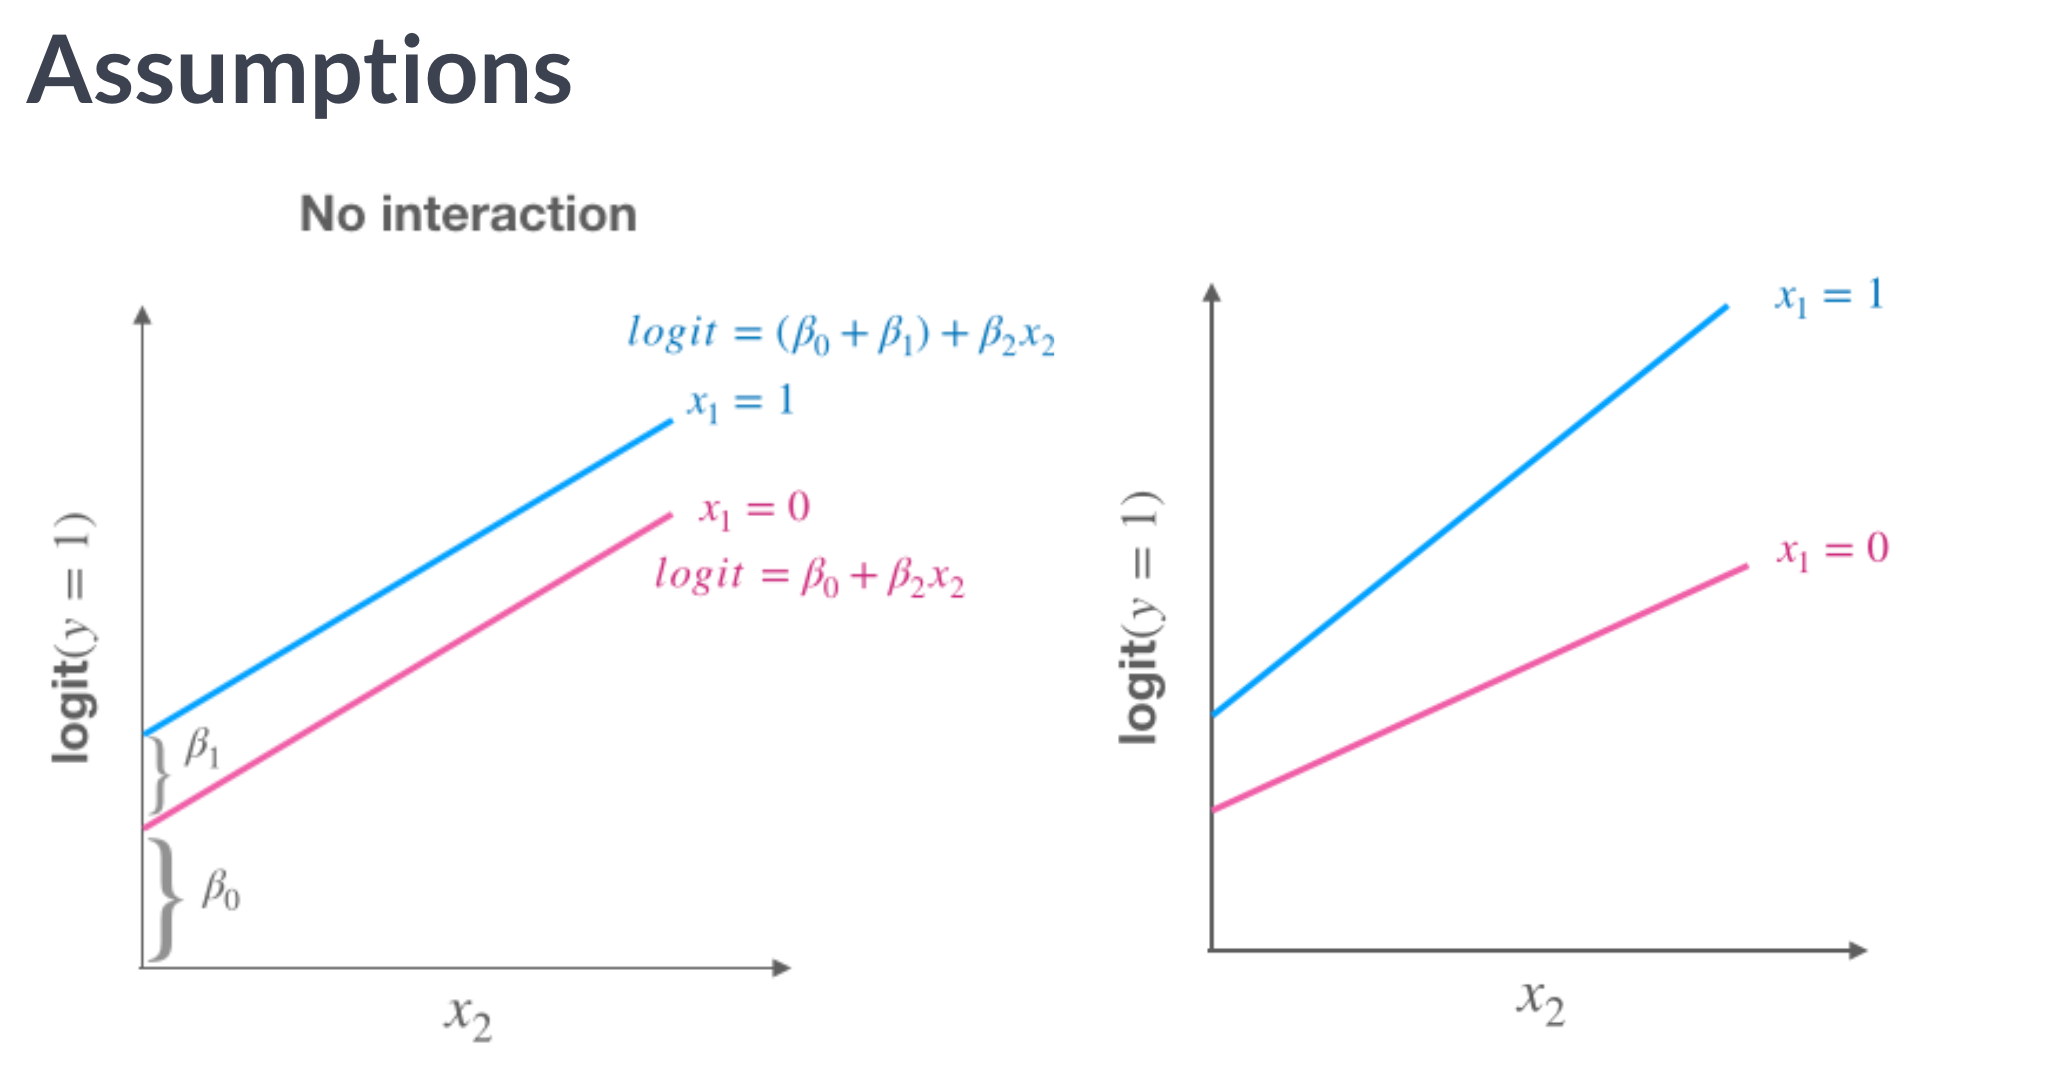

In [52]:
print('The model on the right will fail')

Image('covarianceassumptions.png', width=600, height=800)

__Interaction__

If the lines are not parralel there is a presence of interaction between variables

Interaction means that the effect of $x_1$ on y, depends on the level of $x_2$ and vice versa

To account for interactions we must introduce a third variable, parameter $\beta_3$ accounts for the term of $x_1$ * $x_2$

$$ logit(y = 1 | X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \color{red}{\beta_3 x_1 x_2} $$

If $x_1 = 0$ then

$$ logit(y = 1 | \color{red}{x_1 = 0}, x_2) = \beta_0 + \color{red}{0} + \beta_2 x_2 + \color{red}{0} $$

If $x_1 = 1$ then

$$ logit(y = 1 | \color{red}{x_1 = 1}, x_2) = \beta_0 + \color{red}{\beta_1} + \beta_2 x_2 + \color{red}{\beta_3 x_2} $$

$$ logit(y = 1 | \color{red}{x_1 = 1}, x_2) = (\beta_0 + \color{red}{\beta_1}) + (\beta_2 + \color{red}{\beta_3}) x_2 $$

Interactions allow for the intercept and the slop to differ

$\beta_1$ is the difference between the two intercepts, 

$\beta_3$ is the difference between the two slops

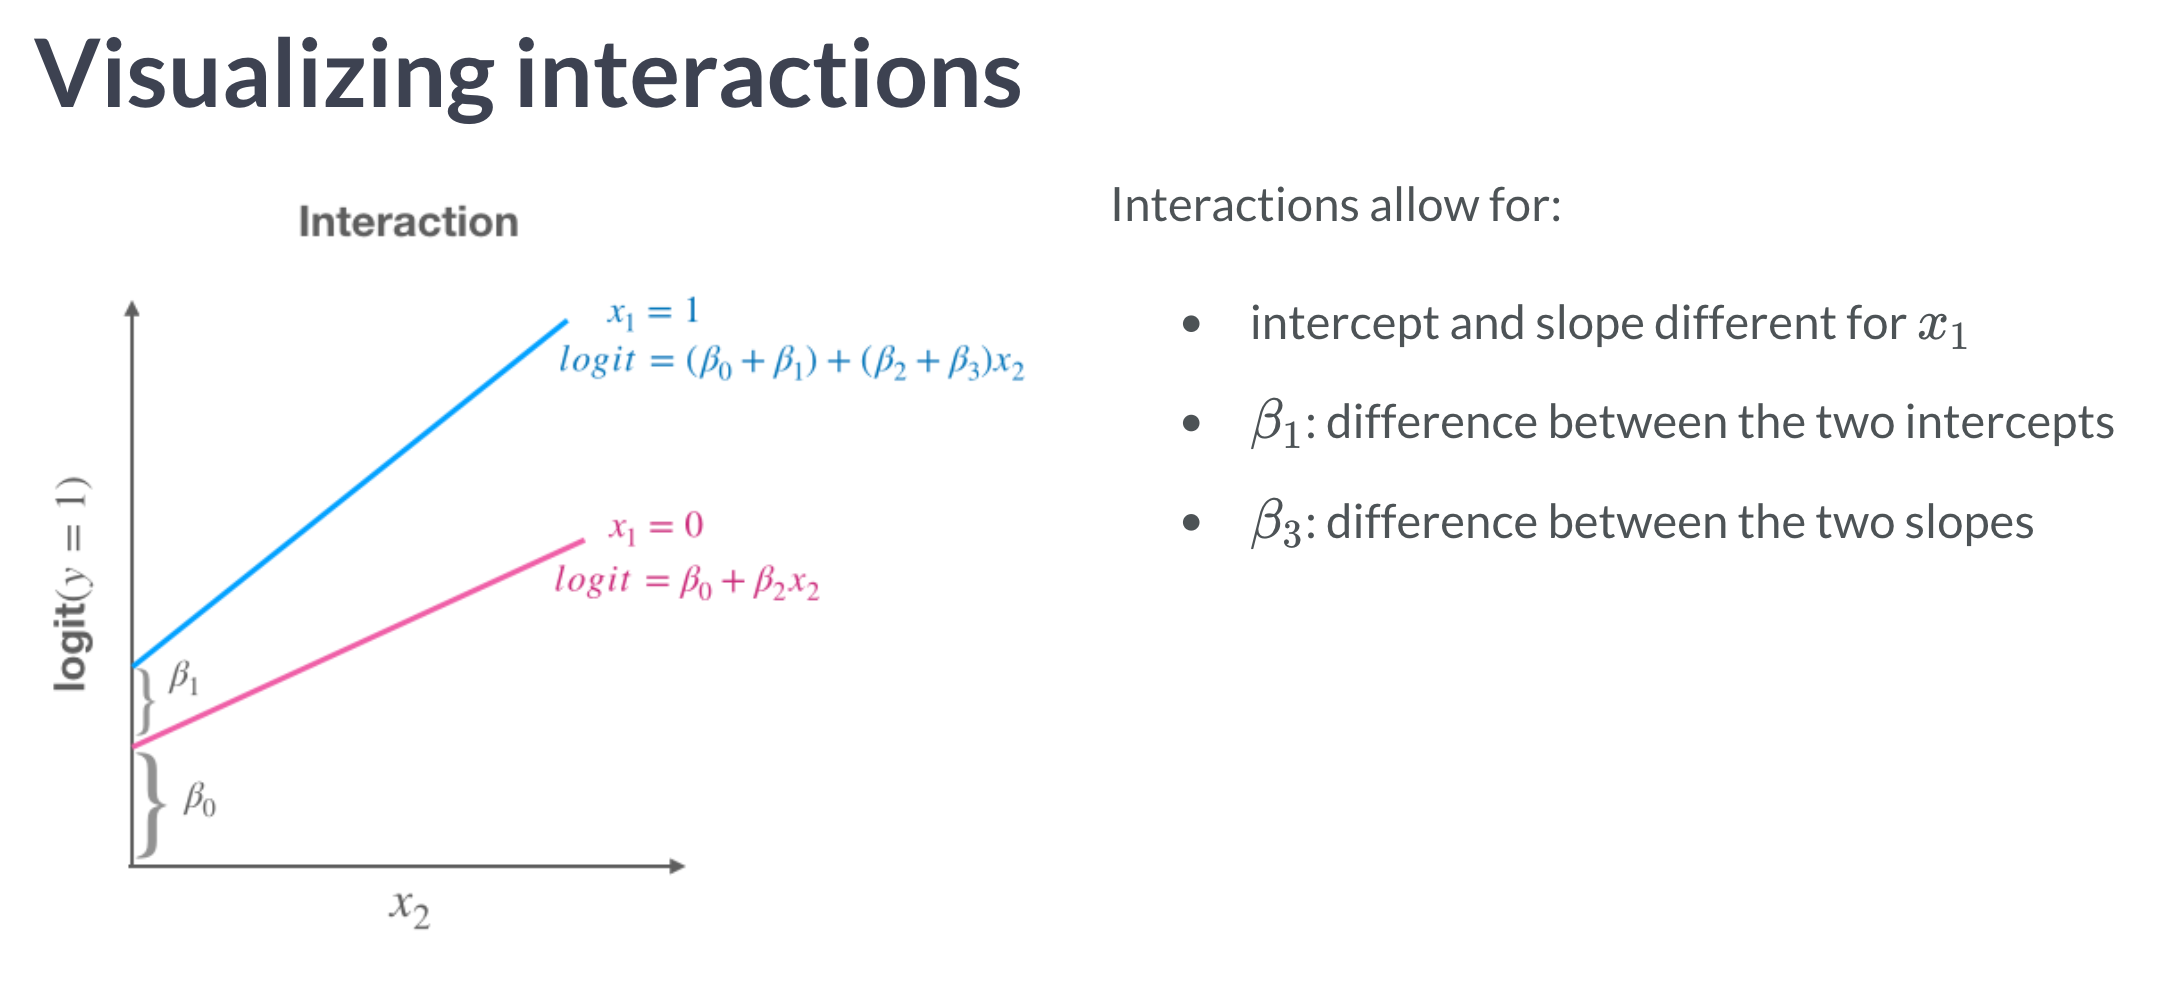

In [54]:
Image('visinteractions.png', width=800, height=800)

In [57]:
# The color variable has a natural ordering as follows:
# 1: medium light
# 2: medium
# 3: medium dark
# 4: dark

# Construct model matrix
model_matrix = dmatrix('C(color, Treatment(4))' , data = df_crab, 
                       return_type = 'dataframe')

# Print first 5 rows of model matrix dataframe
model_matrix.head()

,Intercept,"C(color, Treatment(4))[T.1]","C(color, Treatment(4))[T.2]","C(color, Treatment(4))[T.3]"
0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0


In [59]:
# Fit and print the results of a glm model with the above model matrix configuration
model = glm('y ~ C(color, Treatment(4))', data = df_crab, 
            family = sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      169
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -106.03
Date:                Wed, 22 Apr 2020   Deviance:                       212.06
Time:                        18:41:36   Pearson chi2:                     173.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.7621      0.458     -1.665      0.096      -1.659       0.135
C(color, Treatment(4))[T.1]     1.8608      0.809      2.301      0.021       0.276       3.446
C(color, Treatment(4))[T.2]     1.7382      0.512      3.393      0.001       0.734       2.742
C(color, Treatment(4))[T.3]     1.1299      0.551      2.051      0.040       0.050       2.210
===============================================================================================
"""

The estimated odds that a crab with color_2 (medium) has a satellite nearby are 5.687 times the estimated odds that a crab with color_4 (dark) has a satellite present

Remember we use exponentiation to go from log odds to odd - ie e<sup>x</sup> 

In [64]:
round(np.exp(model.params['C(color, Treatment(4))[T.2]']),3)

5.687

In [65]:
# Add width
model = glm('y ~ C(color, Treatment(4)) + width', data = df_crab, 
            family = sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      168
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -93.729
Date:                Wed, 22 Apr 2020   Deviance:                       187.46
Time:                        18:49:12   Pearson chi2:                     169.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -12.7151      2.762     -4.604      0.000     -18.128      -7.302
C(color, Treatment(4))[T.1]     1.3299      0.853      1.560      0.119      -0.341       3.001
C(color, Treatment(4))[T.2]     1.4023      0.548      2.557      0.011       0.327       2.477
C(color, Treatment(4))[T.3]     1.1061      0.592      1.868      0.062      -0.054       2.267
width                           0.4680      0.106      4.434      0.000       0.261       0.675
===============================================================================================
"""

In [66]:
round(np.exp(model.params['width']),3)

1.597

A one-unit increase in width has multiplicative effect of 1.5967 on the odds that the satellite is nearby for all color groups

In [67]:
# the interaction terms are constructed using semicolon :
model_int = glm('switch ~ center(distance100) + center(arsenic) + center(distance100):center(arsenic)', 
                data = df_wells, family = sm.families.Binomial()).fit()

# View model results
print(model_int.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3006
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.2
Date:                Wed, 22 Apr 2020   Deviance:                       3912.4
Time:                        18:55:05   Pearson chi2:                 3.08e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

> To interpret the interaction parameter we need to consider the effect of its coefficient on both arsenic and distance100 estimates. Hence, for a one-unit change in the explanatory variable the interaction coefficient is added to each coefficient for individual variable.

The value of the interaction term is -0.1744, therefore when added to arsenic's coefficient (0.4713) is decreases arsenic's importance

However when added to distance's coefficient (-0.8834), it increases the importance of distance

At average value of distance100 and arsenic the probability of switching from the current well is equal to:

```
np.exp(model_int.params['Intercept'])/(1+np.exp(model_int.params['Intercept'])) = 0.59
```

In [71]:
round(np.exp(model_int.params['Intercept'])/(1+np.exp(model_int.params['Intercept'])),2)

0.59

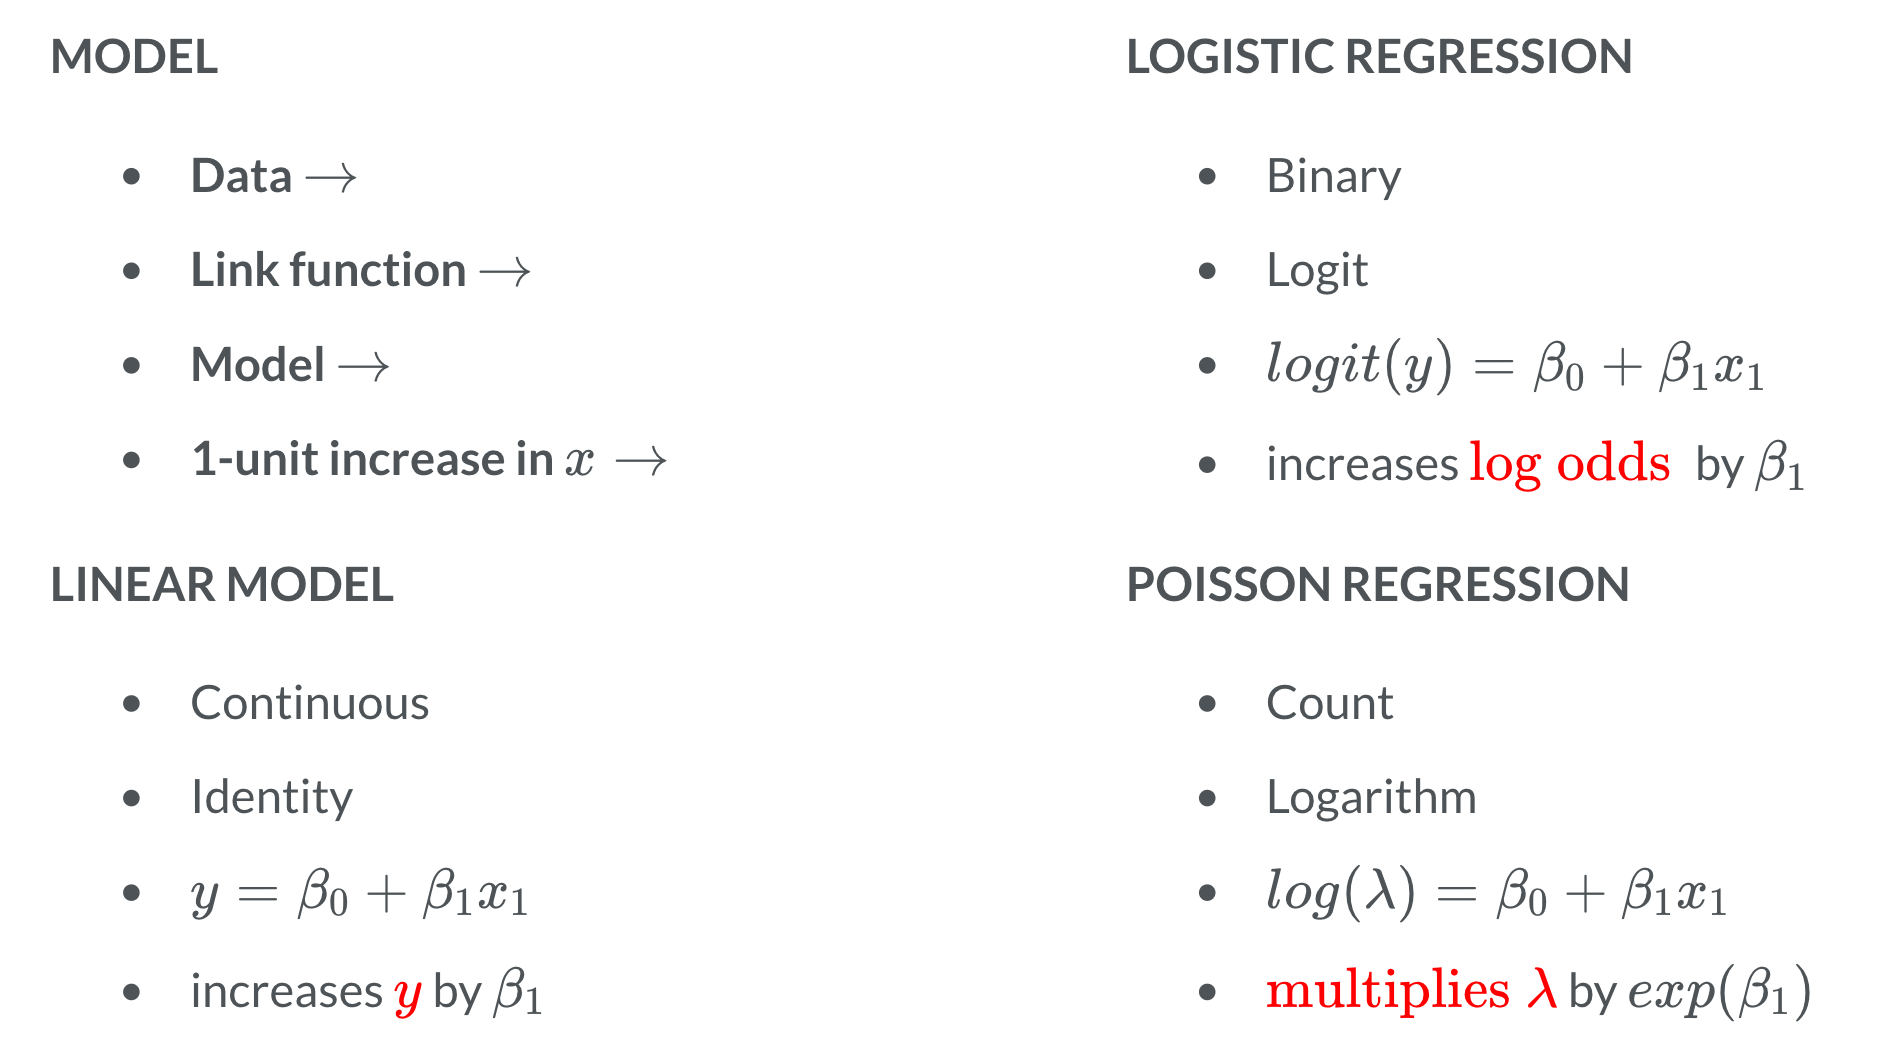

In [72]:
Image('modelsummary.png', width=800, height=800)